A =

   2.067227
  -1.805799
   0.797301
  -0.057861



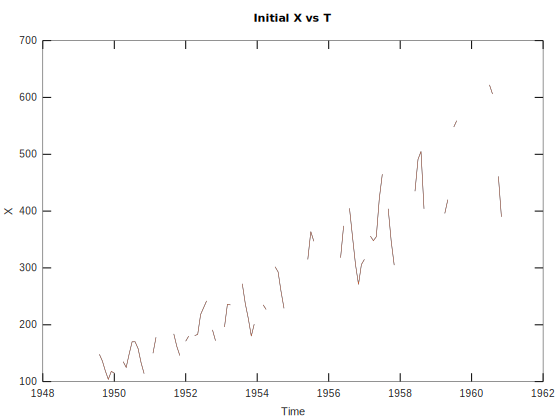

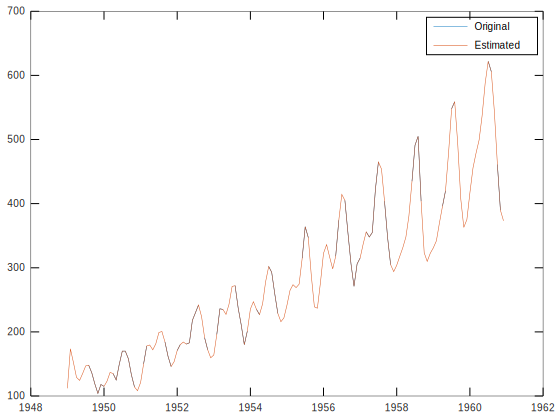

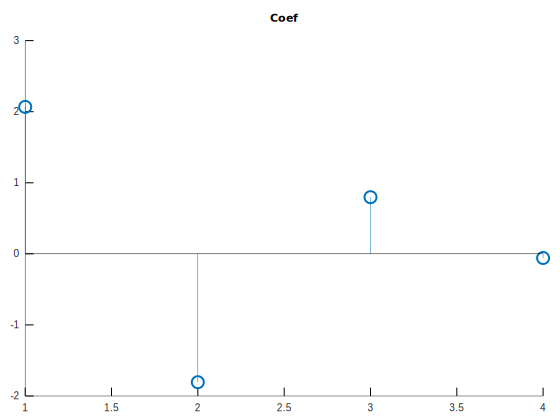

In [13]:
Data = csvread('flights.csv');
T = Data(2:end,1);
X = Data(2:end,2);
X_plot = X;
missing_obs_ind = find(X==0);
observed_ind = find(X!=0);
X_plot(X==0)=nan;
%Ploting initial T and X
plot(T,X_plot);
title('Initial X vs T ')
ylabel('X')
xlabel('Time')
axis('auto x')
hold on;
M = 4;
N = length(X);
observed_size = length(observed_ind);
missing_size = length(missing_obs_ind);
X_mi = zeros(missing_size,1);
X_obs = zeros(observed_size,1);
X_i = X;
X_obs= X(observed_ind);
%initialize X_mi
me = sum(X(observed_ind))/observed_size;
for i=1:length(missing_obs_ind)
    X_mi(i) = 0;
    X_i(missing_obs_ind(i)) = X_mi(i);
end
hold on;
plot(T,X_plot);
for ite=1:20
    G_x = create_gx(X_i,N,M);
    X_mn = X_i(M+1:end);
    %% Solve for A
    A = solveQR(G_x,X_mn);
    %% A is known
    %% Solve for X_i
    G_A = create_ga(A(M:-1:1),M,N,0);
    G_A_obs = G_A(:,observed_ind);
    G_A_mis = G_A(:,missing_obs_ind);
    y = -1*(G_A_obs * X_obs);
    X_mi = solveQR(G_A_mis,y);
    
    for k = 1:missing_size
        X_i(missing_obs_ind(k)) = X_mi(k);
    end
end
A
figure;
plot(T,X_plot);
hold on;
%X_i(observed_ind) = nan;
plot(T,X_i);
legend('Original','Estimated');
figure;
stem(A);
title('Coef')
function A = solveQR(G_x,X)
        [Q_x,R_x] = qr(G_x,0);
        A = R_x \ (Q_x'*X);
end
function r_G = c_reduce(G,missing_obs_ind)
    r_G = G';
    r_G = (r_G(missing_obs_ind,:))';
end
function G_x = create_gx(X,N,M)
    G_x = zeros(N-M,M);
    for i=1:N-M
        for j=M:-1:1
            G_x(i,M-j+1) = X(j+i-1);
        end
    end
end
function G_A = create_ga(A,M,N,index)
    G_A = zeros(N-M,N);
    for i=1:N-M
        G_A(i,i:i+M-1) = A';
        G_A(i,i+M) = -1;
    end
    
end